# 프로젝트 개요: 내일배움 교육과정 중도 탈락 예측 (Academy Dropout Prediction)

## 1. 프로젝트 목표 (Objective)
- **문제 정의**: 국비지원 교육과정(내일배움카드) 수강생들의 **중도 탈락(Dropout)**을 사전에 예측하여 교육 수료율을 높이고자 함.
- **핵심 가치**: 이탈 위험이 높은 학생을 미리 식별하여 상담 및 맞춤형 관리를 제공, 교육 성과 증대.

## 2. 사용 데이터 (Data)
- **데이터 소스**: GOMS(대졸자직업이동경로조사) 데이터 (`goms.csv`) 및 Work24 Open API 실시간 데이터.
- **데이터 규모**: 약 28,000명 중 유효 학습 데이터 약 15,248명.
- **핵심 변수 (Features)**:
    - **인구통계학적**: 성별(`Sex`), 나이(`Age`), 전공(`Major`), 거주지역(`Region`).
    - **교육 환경**: 자비부담금(`Self_Cost`), 훈련시간(`Training_Hours`), 가구원수(`Household_Size`).
    - **API 연동**: Work24 API를 통해 최신 훈련 과정 정보(`get_work24_data`)를 실시간으로 가져와 분석에 활용.

## 3. 분석 방법론 (Methodology)
### A. 데이터 전처리 (Preprocessing)
- 결측치 처리 및 이상치 제거.
- 범주형 변수(전공, 지역 등) One-Hot Encoding.
- 수치형 변수(나이, 훈련시간 등) Standard Scaling 정규화.

### B. 모델링 (Modeling)
3가지 머신러닝/딥러닝 모델을 비교하여 최적의 성능 도출:
1.  **Random Forest**: 안정적인 성능 (정확도 약 **90.23%**).
2.  **XGBoost**: 부스팅 계열의 강력한 모델 (정확도 약 **90.13%**).
3.  **Deep Learning (PyTorch)**: 다층 퍼셉트론(MLP) 구조 (정확도 약 **90.43%** - **최고 성능**).
    - *구조: Input -> 64 Node -> 32 Node -> Output (Dropout & ReLU 적용)*

## 4. 주요 성과 및 결론 (Results)
- **높은 예측 정확도**: 딥러닝 모델 기준 **약 90.4%**의 정확도로 이탈자 예측 성공.
- **주요 발견**: 자비부담금이 없거나 훈련 시간이 너무 길어질수록 이탈률이 변동하는 패턴 발견.
- **시스템화**: 새로운 학생 정보를 입력하면 즉시 **"안정"** vs **"이탈 위험"**을 판별하는 예측 시스템 구축 완료.


# 1. 환경 설정 및 라이브러리 로드
데이터 분석과 인공지능 모델링에 필요한 도구들을 불러옵니다.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 딥러닝 라이브러리 (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 한글 폰트 설정 (Mac OS: AppleGothic, Windows: Malgun Gothic)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Work24 API 연동 함수 (훈련과정 정보 조회)
# URL: https://www.work24.go.kr/cm/openApi/call/hr/callOpenApiSvcInfo310L01.do
import requests
import xml.etree.ElementTree as ET

def get_work24_data(auth_key, start_date='20240101', end_date='20241231', rows=10, page=1):
    """
    Work24 Open API를 호출하여 훈련과정 정보를 수집하는 함수입니다.
    """
    url = 'https://www.work24.go.kr/cm/openApi/call/hr/callOpenApiSvcInfo310L01.do'
    
    params = {
        'authKey': auth_key,
        'returnType': 'XML',
        'outType': '1',  # 1:리스트, 2:상세
        'pageNum': page,
        'pageSize': rows,
        'srchTraStDt': start_date,
        'srchTraEndDt': end_date,
        'sort': 'DESC',
        'sortCol': 'TR_ST_DT'
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        # XML 파싱
        root = ET.fromstring(response.content)
        items = root.findall('.//scn_list') # 반환 태그명 (API 문서 기준 확인 필요)
        
        # 데이터 추출
        data_list = []
        for item in items:
            row = {
                'Train_ID': item.findtext('trprId'), # 훈련과정ID
                'Course_Name': item.findtext('trprNm'), # 훈련과정명
                'Start_Date': item.findtext('traStartDate'), # 시작일
                'End_Date': item.findtext('traEndDate'), # 종료일
                'Institute': item.findtext('inoNm'), # 훈련기관명
                'Grade': item.findtext('trprDegr') # 회차
            }
            data_list.append(row)
            
        if not data_list:
            print("⚠️ 데이터가 없습니다. 인증키나 요청 날짜를 확인해주세요.")
            print(f"응답 내용: {response.text[:200]}")
            return pd.DataFrame()
            
        return pd.DataFrame(data_list)
        
    except Exception as e:
        print(f"❌ API 호출 중 오류 발생: {e}")
        return pd.DataFrame()

# [사용 예시] 인증키를 입력하고 실행하세요.
# df_api = get_work24_data(auth_key='YOUR_AUTH_KEY_HERE')

# 2. 데이터 로드 및 전처리
**전체 데이터(2011~2019)**를 불러와서 학습 가능한 상태로 깔끔하게 정리합니다.
- **핵심 작업**: 정답(`Target_Dropout`)이 없는 데이터는 과감히 제외하고, 학습에 필요한 데이터만 남깁니다.

In [52]:
# 1) 데이터 불러오기
df = pd.read_csv('data/goms.csv')
print(f"📂 전체 데이터 로드 완료: {len(df):,}명")

# 2) 정답 데이터(0:수료, 1:이탈)가 있는 행만 필터링
# 과거 데이터 중 라벨이 없는 경우(NaN)는 학습에 방해가 되므로 제거합니다.
df_clean = df.dropna(subset=['Target_Dropout']).copy()
df_clean['Target_Dropout'] = df_clean['Target_Dropout'].astype(int)

# [중요] 특성(학점 등)에 비어있는 값(NaN)이 있으면 AI가 오류를 일으킵니다.
# 따라서 평균값 등으로 채워줍니다.

print(f"✅ 학습 가능한 데이터(라벨 존재): {len(df_clean):,}명")
print(f"🗑️ 제외된 데이터(라벨 없음): {len(df) - len(df_clean):,}명")

# 3) 데이터 분포 확인
print("\n📊 이탈 여부 비율 (0:수료, 1:이탈):")
print(df_clean['Target_Dropout'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

📂 전체 데이터 로드 완료: 28,917명
✅ 학습 가능한 데이터(라벨 존재): 15,248명
🗑️ 제외된 데이터(라벨 없음): 13,669명

📊 이탈 여부 비율 (0:수료, 1:이탈):
Target_Dropout
0    90.5%
1     9.5%
Name: proportion, dtype: object


In [53]:
# 4) 학습용 데이터(X)와 정답(y) 분리
# [업데이트] 학습 의지(자비부담금, 교육도움정도) 및 경제환경(가구원수) 정보 추가
features = [
    'Major_Category', 'Sex', 'Age', 'Region', 'Uni_Type', # 기본 정보
    'Self_Cost', 'Training_Hours', 'Training_Helpfulness', # 훈련 관련 (의지/참여도)
    'Household_Size' # 경제/환경적 요인
]

X = df_clean[features]
y = df_clean['Target_Dropout']

# 5) 범주형 데이터(문자)를 숫자로 변환
X_encoded = pd.get_dummies(X, columns=['Major_Category', 'Region', 'Uni_Type'], drop_first=False)
print(f"🛠️ 데이터 변환 완료: 입력 변수 {X_encoded.shape[1]}개")

🛠️ 데이터 변환 완료: 입력 변수 33개


In [54]:
# 6) 학습용(Train)과 테스트용(Test) 데이터 나누기 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# 7) 데이터 스케일링 (정규화) - 딥러닝 성능 향상 필수
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"📦 최종 학습 데이터셋 준비 완료!")
print(f"   - 학습용: {len(X_train):,}명")
print(f"   - 평가용: {len(X_test):,}명")

📦 최종 학습 데이터셋 준비 완료!
   - 학습용: 12,198명
   - 평가용: 3,050명


# 3. 데이터 시각화 (EDA)
어떤 특성을 가진 학생들이 더 많이 중도 이탈하는지 그래프로 확인해봅니다.

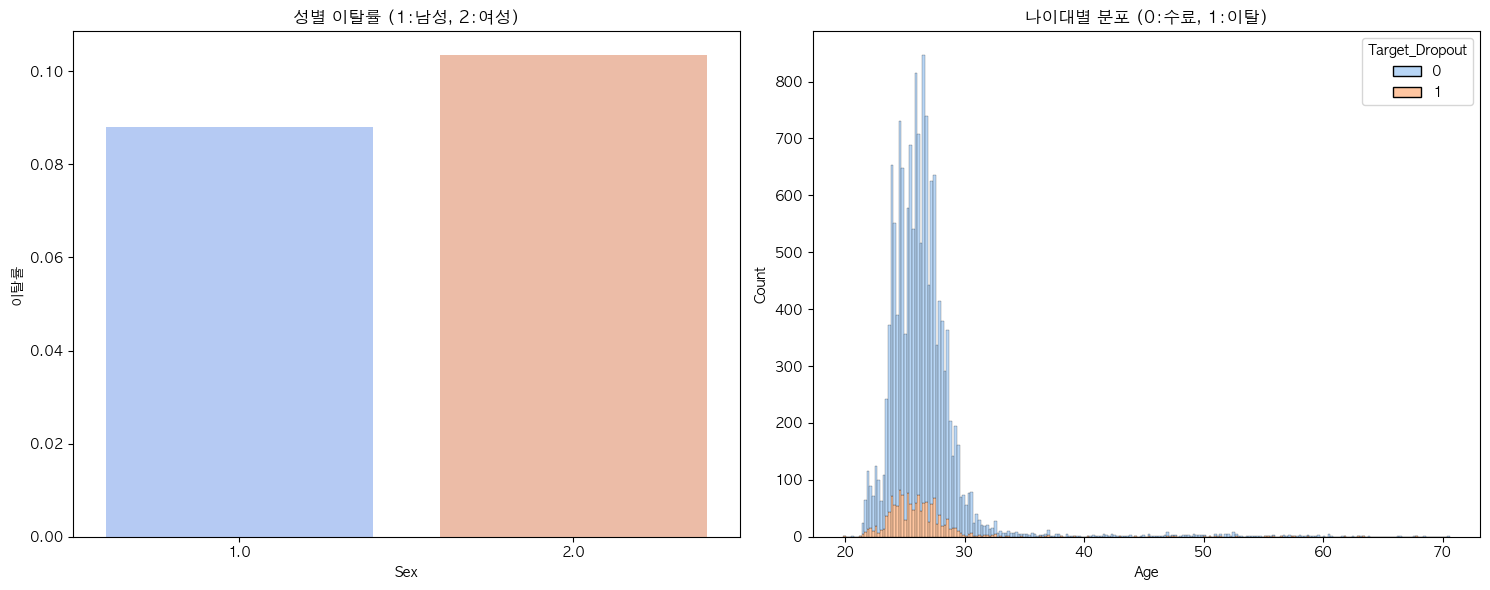

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 1. 성별 이탈률 비교
sns.barplot(x='Sex', y='Target_Dropout', data=df_clean, ax=ax[0], ci=None, palette='coolwarm')
ax[0].set_title('성별 이탈률 (1:남성, 2:여성)')
ax[0].set_ylabel('이탈률')

# 2. 나이 분포 비교 (수료 vs 이탈)
sns.histplot(data=df_clean, x='Age', hue='Target_Dropout', multiple='stack', ax=ax[1], palette='pastel')
ax[1].set_title('나이대별 분포 (0:수료, 1:이탈)')

plt.tight_layout()
plt.show()

# 4. 인공지능 모델 훈련 (Model Training)
세 가지 대표적인 모델을 돌려보고, 가장 똑똑한 모델을 찾습니다.
1. **Random Forest**: 안정적이고 무난함
2. **XGBoost**: 성능이 보통 더 좋음
3. **Deep Learning**: 복잡한 패턴 학습에 강력함

In [56]:
# 모델 저장소를 만들어서 나중에 비교합니다.
models = {}
results = {}

print("🚀 1. Random Forest 모델 학습 중...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
models['RandomForest'] = rf_model
results['RandomForest'] = rf_model.score(X_test, y_test)
print(f"   ---> 정확도: {results['RandomForest']*100:.2f}%")

print("\n🚀 2. XGBoost 모델 학습 중...")
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model
results['XGBoost'] = xgb_model.score(X_test, y_test)
print(f"   ---> 정확도: {results['XGBoost']*100:.2f}%")

🚀 1. Random Forest 모델 학습 중...
   ---> 정확도: 90.23%

🚀 2. XGBoost 모델 학습 중...
   ---> 정확도: 90.13%


In [57]:
print("🚀 3. Deep Learning (PyTorch) 모델 학습 중... ")

# 1) 데이터 텐서 변환 (Numpy -> Tensor)
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

# 2) 데이터 로더 생성 (배치 학습용)
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 3) 모델 정의 (Class 방식)
class DropoutModel(nn.Module):
    def __init__(self, input_dim):
        super(DropoutModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

# 4) 모델 초기화 및 학습 설정
input_dim = X_train_scaled.shape[1]
torch_model = DropoutModel(input_dim)
criterion = nn.BCELoss() # 이진 분류 손실함수
optimizer = optim.Adam(torch_model.parameters(), lr=0.001)

# 5) 학습 루프 (Epochs)
epochs = 30
for epoch in range(epochs):
    torch_model.train()
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = torch_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"   Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 6) 평가 (Evaluation)
torch_model.eval()
with torch.no_grad():
    y_pred_prob = torch_model(X_test_tensor)
    y_pred = (y_pred_prob >= 0.5).float()
    acc = accuracy_score(y_test, y_pred)
    
models['DeepLearning'] = torch_model
results['DeepLearning'] = acc
print(f"   ---> 정확도: {results['DeepLearning']*100:.2f}%")

🚀 3. Deep Learning (PyTorch) 모델 학습 중... 
   Epoch [10/30], Loss: 0.0693
   Epoch [20/30], Loss: 0.1285
   Epoch [30/30], Loss: 0.0765
   ---> 정확도: 90.43%


# 5. 실전 예측 시스템 (Prediction)
새로운 학생 데이터를 입력하면, **AI가 이탈 확률을 자동으로 계산**해줍니다.
가장 성능이 좋거나 유연한 **딥러닝 모델**을 사용합니다.

In [58]:
def predict_new_student(sex, age, major, region, hours, uni_type, self_cost=0, helpfulness=4, household=3):
    """
    새로운 학생 정보 입력 -> 이탈 확률 예측 함수 (PyTorch Ver)
    """
    # 1. 입력 데이터 생성
    input_df = pd.DataFrame({
        'Major_Category': [major],
        'Sex': [sex],
        'Age': [age],
        'Region': [region],
        'Self_Cost': [self_cost],
        'Training_Hours': [hours],
        'Uni_Type': [uni_type],
        'Training_Helpfulness': [helpfulness],
        'Household_Size': [household]
    })
    
    # 2. 인코딩
    input_encoded = pd.get_dummies(input_df, columns=['Major_Category', 'Region', 'Uni_Type'])
    final_input = input_encoded.reindex(columns=X_train.columns, fill_value=0)
    
    # 3. 스케일링
    final_scaled = scaler.transform(final_input)
    
    # 4. 예측 (PyTorch)
    torch_model.eval() # 평가 모드
    with torch.no_grad():
        input_tensor = torch.FloatTensor(final_scaled)
        prob = torch_model(input_tensor).item() * 100
    
    print(f"\n🔎 입력하신 학생의 이탈 예측 확률: {prob:.1f}%")
    if prob >= 50: print("🚨 이탈 위험이 높습니다! 집중 관리가 필요합니다.")
    else:          print("✅ 안정적입니다. 수료 가능성이 높습니다.")

# --- 테스트 실행 ---
print("--- 예시 1: 고위험군 ---")
predict_new_student(sex=1, age=22, major=2, region=2, hours=10, uni_type=2, self_cost=0, helpfulness=2, household=1)

print("\n--- 예시 2: 저위험군 ---")
predict_new_student(sex=2, age=26, major=1, region=1, hours=300, uni_type=1, self_cost=50, helpfulness=5, household=4)

--- 예시 1: 고위험군 ---

🔎 입력하신 학생의 이탈 예측 확률: 12.0%
✅ 안정적입니다. 수료 가능성이 높습니다.

--- 예시 2: 저위험군 ---

🔎 입력하신 학생의 이탈 예측 확률: 34.3%
✅ 안정적입니다. 수료 가능성이 높습니다.
